# Chicago City Taxi Demand Forecast

# Project Outline

1. Introduction  

2. Data Collection  
 2.1 Data Description 

3. Data Wrangling  

4. Exploratory Data Analysis   
 4.1 Serial Autocorrelation Analysis  
 4.2 Spatial Autocorrelation Analysis  

5. Modeling and Validation  
 5.1 Spliting training and testing  
 5.2 Data Veiw  
 5.3 Linear Regression    
 5.4 Support Vector Machine  
 5.5 Random Forest  
 5.6 Logistic  
 5.7 XgBoost  
 5.8 Validation 

       

<br> <br> 

# 1.Introduction

This project selected Chicago taxi travel data from October 1, 2022 to November 30, 2022, combined with hourly weather data, census data and socioeconomic characteristics, and established four prediction models. It is verified that the best model fitting degree can reach 0.763. In addition, I also calculated the number of taxis per hour and per census tract to explore its temporal and spatial autocorrelation.

# 2.Data Collection

There are three different data sources I have chosen for this project:
1.	Chicago taxi trip records: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew  
The data comes from a dataset collected by the official Chicago Data Portal data portal. I chose to go for two months of trip data, and to avoid the impact of specific holidays that might disrupt expected demand on a given weekend or weekday, I chose a study period of two months of data from October 1, 2022 to November 30, 2022, avoiding national holidays (e.g., Christmas).
2.	weather data: https://www.visualcrossing.com/weather/weather-data-services  
I collected hourly weather data from visual crossing for Chicago from October to November 2022 and chose three metrics as predictor variables, including temperature, precipitation and wind speed.
3.	Census and Sociodemographic information  
I used the CenPy library to explore and query the US Census API and return Pandas Dataframes. I obtained median income, race (calculated as the proportion of the population that is white), age, and calculated average commuting time and public transport preferences as predictor variables.


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from cenpy import products
from dplython import sift
from datetime import datetime
from pytz import timezone
import time
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

D:\anaconda\anacon\envs\py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\anacon\envs\py38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda\anacon\envs\py38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8264\1558417168.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can eith

Import Chicago taxi trip data

In [2]:
taxi_trips = pd.read_csv('Taxi_Trips.csv')
taxi_trips.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,71ae3b223fa6bf2c98024be2d037c432c838bdfb,5bee5f6487e84f44cf772c1e26d79f8d82e30539c71bf8...,10/01/2022 12:00:00 AM,10/01/2022 12:00:00 AM,480.0,1.40,1.703108e+10,1.703108e+10,8.0,8.0,...,8.50,Cash,Taxi Affiliation Services,41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),37.0
1,c2474fe7418cc6f03c1ab4b59bcd78b178acda22,342474dd3a24c9d5b7dbc2514032a01ecb396624638be5...,10/01/2022 12:00:00 AM,10/01/2022 12:30:00 AM,1800.0,12.30,1.703198e+10,1.703108e+10,56.0,8.0,...,46.00,Credit Card,Taxi Affiliation Services,41.785999,-87.750934,POINT (-87.7509342894 41.785998518),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),53.0
2,a8e8d9968ab7aeb4224055998cae9a4ca71bad6c,1897ed17bef32c8721aaeffd8239d3e1a49222c0eb602b...,10/01/2022 12:00:00 AM,10/01/2022 01:00:00 AM,3137.0,23.19,NaN,NaN,NaN,76.0,...,63.50,Cash,Sun Taxi,NaN,NaN,NaN,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN
3,dc47e7847eb3afa0cd5508e656b16ae60f62f212,18f90b0ff78ff47db3ac51fcb52cc5a8fdfb45abdf9982...,10/01/2022 12:00:00 AM,10/01/2022 12:15:00 AM,1345.0,5.63,NaN,NaN,14.0,77.0,...,27.65,Mobile,City Service,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),14.0
4,c0d217cae8e1e5054f0f58266b6e82e203c85bcd,9e00db075b98e6b900e33ebc47977f154cd3aaae5385b1...,10/01/2022 12:00:00 AM,10/01/2022 12:30:00 AM,1870.0,10.42,NaN,NaN,38.0,51.0,...,28.50,Prcard,Medallion Leasin,41.812949,-87.617860,POINT (-87.6178596758 41.8129489392),41.690633,-87.570058,POINT (-87.5700582686 41.6906333472),4.0


Import weather data

In [3]:
weather_chicago = pd.read_excel('weather-Chicago-20221001-20221130.xlsx')
# select temperature, precipitation and wind speed
w_chicago = weather_chicago[['datetime','temp','precip','windspeed']]
# w_chicago.head()

Import Census and Sociodemographic information

In [4]:
chicago = products.ACS(2019).from_place('Chicago, IL', level='tract',
                                        variables=["B01003_001", "B19013_001", 
                                   "B02001_002", "B08013_001",
                                   "B08012_001", "B08301_001", 
                                   "B08301_010", "B01002_001"])

chicago = chicago.rename(columns={
    'B01003_001E': 'Total_Pop',
    'B19013_001E': 'Med_Inc',
    'B01002_001E': 'Med_Age',
    'B02001_002E': 'White_Pop',
    'B08013_001E': 'Travel_Time',
    'B08012_001E': 'Num_Commuters',
    'B08301_001E': 'Means_of_Transport',
    'B08301_010E': 'Total_Public_Trans'
})


Matched: Chicago, IL to Chicago city within layer Incorporated Places


In [5]:
# Select columns of interest
chicago_census = chicago[['Total_Pop', 'Med_Inc', 'White_Pop', 'Travel_Time', 'Means_of_Transport', 'Total_Public_Trans', 'Med_Age', 'GEOID', 'geometry']]

# Calculate additional variables of interest
chicago_census['Percent_White'] = chicago_census['White_Pop'] / chicago_census['Total_Pop']
chicago_census['Mean_Commute_Time'] = chicago_census['Travel_Time'] / chicago_census['Total_Public_Trans']
chicago_census['Percent_Taking_Public_Trans'] = chicago_census['Total_Public_Trans'] / chicago_census['Means_of_Transport']
# chicago_census

census = chicago_census.drop('geometry', axis=1)
census['GEOID'] = census['GEOID'].astype(float)
# census.head()

# 3.Data Wrangling

In [6]:
#Creating a new GeoDataFrame and adding a new column called geometry which contains point objects representing the pickup location of each taxi trip
taxi_trips = gpd.GeoDataFrame(taxi_trips, geometry=gpd.points_from_xy(taxi_trips['Pickup Centroid Longitude'], taxi_trips['Pickup Centroid Latitude']), crs=4326)

In [7]:
#Merged taxi_trips and chicago_census
dat_census = gpd.sjoin(taxi_trips, chicago_census.to_crs(4326), op='intersects', how='left').rename(columns={'GEOID': 'Pickup Centroid Location'})
dat_census['Pickup Centroid Longitude'] = dat_census.geometry.x
dat_census['Pickup Centroid Latitude'] = dat_census.geometry.y
dat_census = dat_census.drop(columns=['geometry'])

In [8]:
#Data Cleaning
dat_census.drop_duplicates(inplace=True)
dat_census.dropna(subset=['Pickup Centroid Location', 'Dropoff Centroid  Location'], thresh=2, inplace=True)
dat_census.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract'], thresh=2, inplace=True)
dat_census.dropna(subset=['Pickup Community Area', 'Dropoff Community Area'], thresh=2, inplace=True)
dat_census.dropna(subset=['Med_Inc', 'Med_Age'], thresh=2, inplace=True)

In [9]:
# join weather data to dat_census
# Convert datetime columns to datetime type
w_chicago['datetime'] = pd.to_datetime(w_chicago['datetime'])
dat_census['Trip Start Timestamp'] = pd.to_datetime(dat_census['Trip Start Timestamp'])
dat_census['Trip End Timestamp'] = pd.to_datetime(dat_census['Trip End Timestamp'])
# Merge the two dataframes using merge_asof
merged = pd.merge_asof(dat_census, w_chicago, left_on='Trip Start Timestamp', right_on='datetime', direction='nearest')

# Drop the datetime column from the merged dataframe
merged.drop('datetime', axis=1, inplace=True)
# merged.info()

In [10]:
merged

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Means_of_Transport,Total_Public_Trans,Med_Age,Pickup Centroid Location,Percent_White,Mean_Commute_Time,Percent_Taking_Public_Trans,temp,precip,windspeed
0,71ae3b223fa6bf2c98024be2d037c432c838bdfb,5bee5f6487e84f44cf772c1e26d79f8d82e30539c71bf8...,2022-10-01 00:00:00,2022-10-01 00:00:00,480.0,1.40,1.703108e+10,1.703108e+10,8.0,8.0,...,2795.0,907.0,40.7,17031081201,0.820420,72.420066,0.324508,13.7,0.0,6.7
1,1c9e6b415aa67bae49da26e4d43c4da873977717,bb4e75d3065311c33024a434640731c43fd2cf9e4482eb...,2022-10-01 00:00:00,2022-10-01 00:15:00,960.0,0.30,1.703108e+10,1.703103e+10,8.0,3.0,...,3345.0,558.0,36.8,17031081500,0.701615,143.978495,0.166816,13.7,0.0,6.7
2,a0dea157e55886184183f6de523a9d1907781ec7,1bb875f74db6b3d8bcab27f6784218036ec738c201e533...,2022-10-01 00:00:00,2022-10-01 00:00:00,1.0,0.00,1.703108e+10,1.703108e+10,8.0,8.0,...,2795.0,907.0,40.7,17031081201,0.820420,72.420066,0.324508,13.7,0.0,6.7
3,6a6aadfed7fb1788f4ab7dae024a895f88fc395f,d899402f96aeec3adabbee95f3a99aba9ade0e0b5c1d93...,2022-10-01 00:00:00,2022-10-01 00:15:00,507.0,1.98,1.703183e+10,1.703108e+10,28.0,8.0,...,3169.0,728.0,33.3,17031833000,0.725446,95.796703,0.229725,13.7,0.0,6.7
4,1a3514e078eb5699b055e46d16ab70ad72b7ac33,005a35095f423d97a46c9015d6602e614addb59fe659b2...,2022-10-01 00:00:00,2022-10-01 00:00:00,307.0,0.69,1.703183e+10,1.703184e+10,28.0,32.0,...,3169.0,728.0,33.3,17031833000,0.725446,95.796703,0.229725,13.7,0.0,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190386,74c9397900a47357261552f12a51b89d26da2587,9b48ad5744e86450fb4db78e7095a6827bafc43a6a9d9a...,2022-11-30 23:45:00,2022-11-30 23:45:00,358.0,1.06,1.703108e+10,1.703132e+10,8.0,32.0,...,2882.0,623.0,33.4,17031081600,0.735891,115.939005,0.216169,-6.2,0.0,16.3
190387,708b3ab3d50500e86955a2d339a4a17cd1944523,5e61d7ef452d7ccbf325ff879ffbf59eeb89f68ec78623...,2022-11-30 23:45:00,2022-12-01 00:00:00,810.0,0.00,1.703184e+10,1.703108e+10,28.0,8.0,...,677.0,245.0,45.5,17031838100,0.317224,99.346939,0.361891,-6.2,0.0,16.3
190388,7c6e8cc5b1153e60762c229dd7ed26cadbba6b82,2db2ec3555e44930a5d41596cb7935af41c30c30381672...,2022-11-30 23:45:00,2022-12-01 00:00:00,864.0,3.20,1.703108e+10,1.703133e+10,8.0,33.0,...,2882.0,623.0,33.4,17031081600,0.735891,115.939005,0.216169,-6.2,0.0,16.3
190389,adfd09995998b239be05813dc72159ee8fc0703a,5067aae3d9e1474101b1df5c6b7fe79389e429ea7d8203...,2022-12-01 00:00:00,2022-12-01 00:00:00,5.0,0.00,1.703108e+10,1.703108e+10,8.0,8.0,...,3305.0,386.0,32.0,17031081700,0.746479,177.279793,0.116793,-6.2,0.0,16.3


In [11]:
merged['interval60'] = merged['Trip Start Timestamp'].dt.floor('H')
merged['week'] = merged['interval60'].dt.isocalendar().week
merged['dotw'] = merged['interval60'].dt.day_name()

In [12]:
# Convert time to datetime
merged['Trip Start Timestamp'] = pd.to_datetime(merged['Trip Start Timestamp'])
merged['Trip End Timestamp'] = pd.to_datetime(merged['Trip End Timestamp'])

w_chicago = w_chicago.rename(columns={'datetime': 'interval60'})
w_chicago['interval60'] = pd.to_datetime(w_chicago['interval60'])

# Convert pickup and dropoff points to GeoDataFrame
pickup_points = gpd.GeoDataFrame(merged, geometry=gpd.points_from_xy(merged['Pickup Centroid Longitude'], merged['Pickup Centroid Latitude']))
dropoff_points = gpd.GeoDataFrame(merged, geometry=gpd.points_from_xy(merged['Dropoff Centroid Longitude'], merged['Dropoff Centroid Latitude']))


In [13]:
trip_count = merged.groupby(['Pickup Census Tract', 'interval60'])['Trip ID'].count().reset_index(name='trip_count')
trip_count = trip_count.sort_values(by='interval60', ascending=True)
trip_count = trip_count.rename(columns={'Pickup Census Tract': 'GEOID'})

In [14]:
trip_count

,GEOID,interval60,trip_count
5904,1.703108e+10,2022-10-01 00:00:00,7
2063,1.703108e+10,2022-10-01 00:00:00,6
10220,1.703183e+10,2022-10-01 00:00:00,12
4928,1.703108e+10,2022-10-01 00:00:00,4
8030,1.703128e+10,2022-10-01 00:00:00,3
...,...,...,...
8918,1.703128e+10,2022-11-30 23:00:00,2
5902,1.703108e+10,2022-11-30 23:00:00,13
6976,1.703108e+10,2022-11-30 23:00:00,7
5903,1.703108e+10,2022-12-01 00:00:00,1


In [15]:
num_geoids = trip_count['GEOID'].nunique()
print("There are", num_geoids, "unique GEOIDs in the taxi DataFrame.")

There are 221 unique GEOIDs in the taxi DataFrame.


In [16]:
# merge census and weather data
trip_count = pd.merge(trip_count,census, on = 'GEOID')
trip_count = trip_count.sort_values(by='interval60', ascending=False)
trip_count['interval60'] = pd.to_datetime(trip_count['interval60'])
trip_count = pd.merge(trip_count,w_chicago, on ='interval60')
trip_count

,GEOID,interval60,trip_count,Total_Pop,Med_Inc,White_Pop,Travel_Time,Means_of_Transport,Total_Public_Trans,Med_Age,Percent_White,Mean_Commute_Time,Percent_Taking_Public_Trans,temp,precip,windspeed
0,1.703108e+10,2022-11-30 23:00:00,13,4040.0,130673.0,2973.0,72230.0,2882.0,623.0,33.4,0.735891,115.939005,0.216169,-6.2,0.0,16.3
1,1.703108e+10,2022-11-30 23:00:00,11,4711.0,94288.0,3865.0,65685.0,2795.0,907.0,40.7,0.820420,72.420066,0.324508,-6.2,0.0,16.3
2,1.703128e+10,2022-11-30 23:00:00,2,6603.0,136389.0,5139.0,128635.0,5475.0,871.0,32.4,0.778283,147.686567,0.159087,-6.2,0.0,16.3
3,1.703128e+10,2022-11-30 23:00:00,3,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-6.2,0.0,16.3
4,1.703183e+10,2022-11-30 23:00:00,5,4480.0,151028.0,3250.0,69740.0,3169.0,728.0,33.3,0.725446,95.796703,0.229725,-6.2,0.0,16.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13451,1.703184e+10,2022-10-01 00:00:00,13,7545.0,101000.0,4480.0,113655.0,5060.0,1419.0,30.0,0.593771,80.095137,0.280435,13.7,0.0,6.7
13452,1.703108e+10,2022-10-01 00:00:00,4,10298.0,149135.0,8216.0,189205.0,8369.0,1008.0,32.9,0.797825,187.703373,0.120444,13.7,0.0,6.7
13453,1.703128e+10,2022-10-01 00:00:00,3,6603.0,136389.0,5139.0,128635.0,5475.0,871.0,32.4,0.778283,147.686567,0.159087,13.7,0.0,6.7
13454,1.703108e+10,2022-10-01 00:00:00,1,4911.0,138173.0,4161.0,102665.0,3717.0,1330.0,31.5,0.847282,77.191729,0.357815,13.7,0.0,6.7


In [17]:
trip_count.to_csv('trip_count.csv', index=False)

# 4.Exploratory Data Analysis

## 4.1 Serial Autocorrelation Analysis

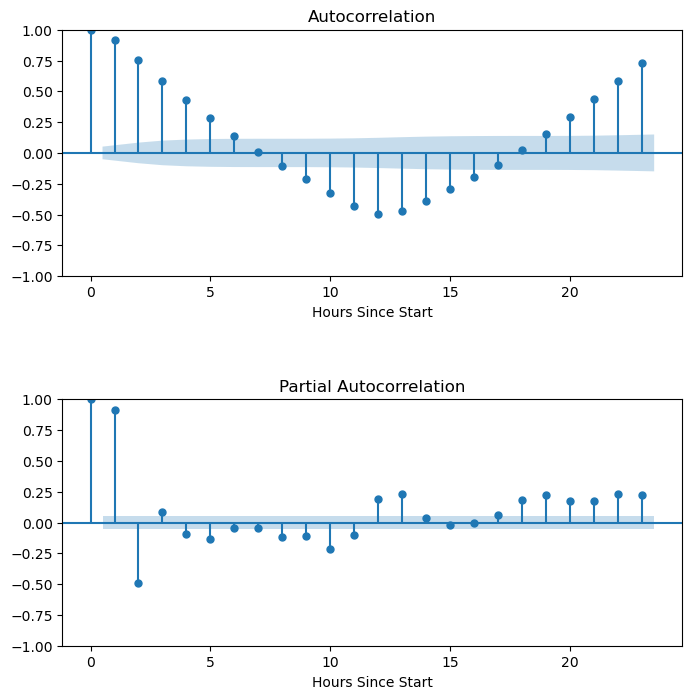

In [18]:
# Set the start and end time
start_time = pd.Timestamp('2022-10-01 00:00:00')
end_time = pd.Timestamp('2022-11-30 23:00:00')

# Create a new dataframe with hourly intervals
time_range = pd.date_range(start=start_time, end=end_time, freq='H')
taxi_count = pd.DataFrame(index=time_range)

# Calculate the total number of taxis per hour
taxi_count['total_taxis'] = trip_count.groupby(trip_count['interval60'].dt.floor('H')).sum()['trip_count']
taxi_count = taxi_count.resample('H').sum().fillna(0)

# Add a time column to the dataframe
taxi_count['time'] = taxi_count.index
taxi_count.reset_index(drop=True, inplace=True)

# Calculate the hours since the start time
taxi_count['hours_since_start'] = (taxi_count['time'] - start_time) // pd.Timedelta(hours=1)


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8,8))
plot_acf(taxi_count['total_taxis'], lags=23, ax=axes[0])
plot_pacf(taxi_count['total_taxis'], lags=23, ax=axes[1])
axes[0].set_xlabel('Hours Since Start')
axes[1].set_xlabel('Hours Since Start')

# Adjust the spacing between the two plots
fig.subplots_adjust(hspace=0.5)

plt.show()

## 4.2 Spatial Autocorrelation Analysis

In [19]:
shapefile_path = "C:/Users/Lenovo/Desktop/Course/GEOG5404M Analytics for Urban Policy (38540)/Final coursework/census.shp"
gdf = gpd.read_file(shapefile_path)
gdf['geoid10'] = gdf['geoid10'].astype(str)
gdf = gdf.rename(columns={'geoid10': 'GEOID'})
gdf['GEOID'] = gdf['GEOID'].astype('float')
# Create a point geometry column for rideshare data
merged['geometry'] = dat_census.apply(lambda x: Point(x['Pickup Centroid Longitude'], x['Pickup Centroid Latitude']), axis=1)
merged = gpd.GeoDataFrame(merged, geometry='geometry')

# Create a count column for the number of rides by start station and week
dat_census_count = merged.groupby(['Pickup Census Tract']).size().reset_index(name='count')

In [20]:
dat_census_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pickup Census Tract  221 non-null    float64
 1   count                221 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 3.6 KB


In [21]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   commarea    801 non-null    object  
 1   commarea_n  801 non-null    float64 
 2   countyfp10  801 non-null    object  
 3   GEOID       801 non-null    float64 
 4   name10      801 non-null    object  
 5   namelsad10  801 non-null    object  
 6   notes       12 non-null     object  
 7   statefp10   801 non-null    object  
 8   tractce10   801 non-null    object  
 9   geometry    801 non-null    geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 62.7+ KB


In [22]:
gdf = gdf.join(dat_census_count.set_index('Pickup Census Tract'), on = 'GEOID')

In [23]:
gdf.to_file('shapefile.shp', driver='ESRI Shapefile')

In [24]:
gdf['count'] = gdf['count'].fillna(0)

In [25]:
gdf

,commarea,commarea_n,countyfp10,GEOID,name10,namelsad10,notes,statefp10,tractce10,geometry,count
0,44,44.0,031,1.703184e+10,8424,Census Tract 8424,NaN,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",68.0
1,59,59.0,031,1.703184e+10,8403,Census Tract 8403,NaN,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",678.0
2,34,34.0,031,1.703184e+10,8411,Census Tract 8411,NaN,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",17.0
3,31,31.0,031,1.703184e+10,8412,Census Tract 8412,NaN,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.0
4,32,32.0,031,1.703184e+10,8390,Census Tract 8390,NaN,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",367.0
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,1.703107e+10,704,Census Tract 704,NaN,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",4.0
797,7,7.0,031,1.703107e+10,705,Census Tract 705,NaN,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",1.0
798,13,13.0,031,1.703113e+10,1303,Census Tract 1303,NaN,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",4.0
799,29,29.0,031,1.703129e+10,2922,Census Tract 2922,NaN,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",0.0


In [26]:
#calculate the queen weights
w_queen = weights.Queen.from_dataframe(gdf, idVariable = 'GEOID')

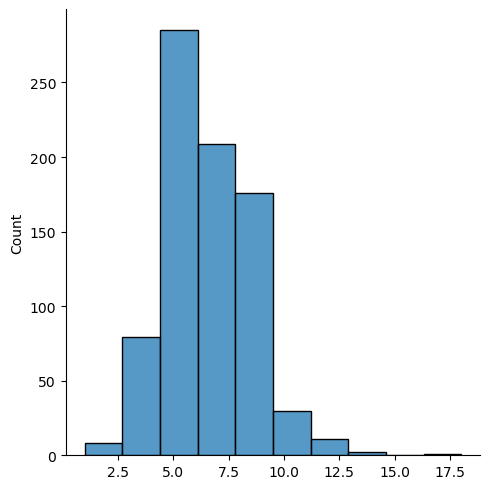

In [27]:
queen_card = pd.Series(w_queen.cardinalities)
sns.displot(queen_card, bins = 10)

In [28]:
w_queen.transform = 'R' #standardise across rows
w_queen_score = weights.lag_spatial(w_queen, gdf['count']) #compute spatial lag of the number of taxi

In [29]:
gdf['W_Q_Score'] = w_queen_score 

In [30]:
moran_scatterplot

<function splot._viz_esda_mpl.moran_scatterplot(moran, zstandard=True, p=None, aspect_equal=True, ax=None, scatter_kwds=None, fitline_kwds=None)>

In [31]:
mi = esda.Moran(gdf['count'], w_queen) #we'll use our queen weights

In [32]:
#print the I value
print(mi.I) 

0.035373886094976346


In [33]:
print(mi.p_sim)

0.03


In [34]:
mi

In [35]:
#calculate LISA clusters
lisa = esda.Moran_Local(gdf['count'], w_queen)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

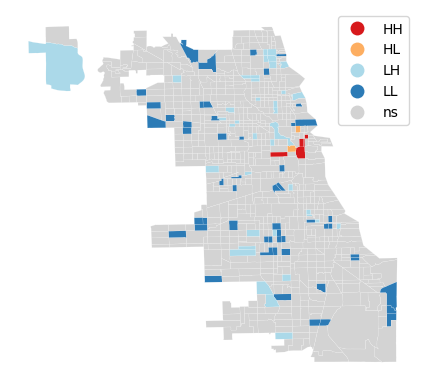

In [36]:
lisa_cluster(lisa, gdf)

# 5. Modeling and Validation

## 5.1 Spliting training and testing

In [37]:
#Taking November 20, 2022 as the node, split two different training and testing data sets according to time
test_data = trip_count[:1825]
train_data = trip_count[1825:]

In [38]:
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [39]:
data = pd.read_csv("train_data.csv")
data.head()

,GEOID,interval60,trip_count,Total_Pop,Med_Inc,White_Pop,Travel_Time,Means_of_Transport,Total_Public_Trans,Med_Age,Percent_White,Mean_Commute_Time,Percent_Taking_Public_Trans,temp,precip,windspeed
0,1.703108e+10,2022-11-20 23:00:00,1,4040.0,130673.0,2973.0,72230.0,2882.0,623.0,33.4,0.735891,115.939005,0.216169,-1.4,0.0,27.0
1,1.703128e+10,2022-11-20 23:00:00,1,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-1.4,0.0,27.0
2,1.703184e+10,2022-11-20 22:00:00,1,7545.0,101000.0,4480.0,113655.0,5060.0,1419.0,30.0,0.593771,80.095137,0.280435,-1.2,0.0,25.9
3,1.703128e+10,2022-11-20 22:00:00,4,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-1.2,0.0,25.9
4,1.703128e+10,2022-11-20 21:00:00,3,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-0.7,0.0,26.5


In [40]:
train_data  = pd.read_csv("train_data.csv")
train_data_feature = train_data.drop(labels="trip_count", axis=1)
train_data_feature["time"] = train_data_feature.apply(lambda x: time.strptime(x["interval60"], "%Y-%m-%d %H:%M:%S").tm_hour, axis=1)
train_data_feature = train_data.drop(labels="interval60", axis=1)
train_data_label = train_data[["trip_count"]]

In [41]:
train_data_feature.head()

,GEOID,trip_count,Total_Pop,Med_Inc,White_Pop,Travel_Time,Means_of_Transport,Total_Public_Trans,Med_Age,Percent_White,Mean_Commute_Time,Percent_Taking_Public_Trans,temp,precip,windspeed
0,1.703108e+10,1,4040.0,130673.0,2973.0,72230.0,2882.0,623.0,33.4,0.735891,115.939005,0.216169,-1.4,0.0,27.0
1,1.703128e+10,1,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-1.4,0.0,27.0
2,1.703184e+10,1,7545.0,101000.0,4480.0,113655.0,5060.0,1419.0,30.0,0.593771,80.095137,0.280435,-1.2,0.0,25.9
3,1.703128e+10,4,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-1.2,0.0,25.9
4,1.703128e+10,3,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-0.7,0.0,26.5


In [42]:
train_data_label.head()

,trip_count
0,1
1,1
2,1
3,4
4,3


In [43]:
test_data  = pd.read_csv("test_data.csv")
test_data_feature = test_data.drop(labels="trip_count", axis=1)
test_data_feature["time"] = test_data_feature.apply(lambda x: time.strptime(x["interval60"], "%Y-%m-%d %H:%M:%S").tm_hour, axis=1)
test_data_feature = test_data.drop(labels="interval60", axis=1)
test_data_label = test_data[["trip_count"]]

In [44]:
test_data_feature.head()

,GEOID,trip_count,Total_Pop,Med_Inc,White_Pop,Travel_Time,Means_of_Transport,Total_Public_Trans,Med_Age,Percent_White,Mean_Commute_Time,Percent_Taking_Public_Trans,temp,precip,windspeed
0,1.703108e+10,13,4040.0,130673.0,2973.0,72230.0,2882.0,623.0,33.4,0.735891,115.939005,0.216169,-6.2,0.0,16.3
1,1.703108e+10,11,4711.0,94288.0,3865.0,65685.0,2795.0,907.0,40.7,0.820420,72.420066,0.324508,-6.2,0.0,16.3
2,1.703128e+10,2,6603.0,136389.0,5139.0,128635.0,5475.0,871.0,32.4,0.778283,147.686567,0.159087,-6.2,0.0,16.3
3,1.703128e+10,3,6221.0,109104.0,3233.0,110825.0,4507.0,863.0,31.7,0.519691,128.418308,0.191480,-6.2,0.0,16.3
4,1.703183e+10,5,4480.0,151028.0,3250.0,69740.0,3169.0,728.0,33.3,0.725446,95.796703,0.229725,-6.2,0.0,16.3


In [45]:
test_data_label.head()

,trip_count
0,13
1,11
2,2
3,3
4,5


## 5.2 Data View

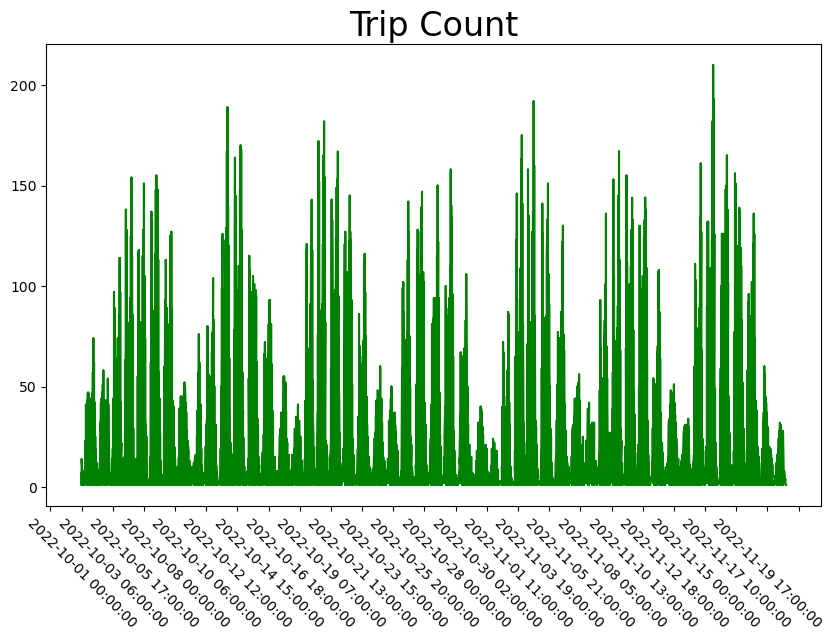

In [46]:
## draw count trend
plt.figure(figsize=(10, 6))
trip_count_time = train_data[["interval60", "trip_count"]].drop_duplicates()
x = trip_count_time["interval60"].tolist()
x.reverse()
y = trip_count_time["trip_count"].tolist()
y.reverse()
plt.plot(x,y,c='g')
plt.title('Trip Count',fontsize=24)
x_major_locator=MultipleLocator(50)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=315)
plt.show()

## 5.3 Support Vector Machine

In [47]:
from sklearn.svm import SVR


svm_reg = SVR().fit(train_data_feature, train_data_label)
y_pred_svm = svm_reg.predict(test_data_feature)

# mae
test_error_svm_mae = mean_absolute_error(test_data_label, y_pred_svm)
print("mae is ", test_error_svm_mae)

# mse
test_error_svm_mse = mean_squared_error(test_data_label, y_pred_svm)
print("mse is ", test_error_svm_mse)

# r2_score
test_r2_score = r2_score(test_data_label, y_pred_svm)
print("r2 is ", test_r2_score)

mae is  11.157534218964784
mse is  461.27399329424287
r2 is  -0.14471748160267772


## 5.4 Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 5)
rfc = rfc.fit(train_data_feature, train_data_label)
y_pred_rfc = rfc.predict(test_data_feature)
# print(test_data_label)
# print(y_pred_rfc)

# mae
test_error_rfc_mae = mean_absolute_error(test_data_label, y_pred_rfc)
print("mae is ", test_error_rfc_mae)

# mse
test_error_rfc_mse = mean_squared_error(test_data_label, y_pred_rfc)
print("mse is ", test_error_rfc_mse)

# r2_score
test_r2_score = r2_score(test_data_label, y_pred_rfc)
print("r2 is ", test_r2_score)

mae is  2.8378082191780822
mse is  97.8131506849315
r2 is  0.757262657016403


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter range
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# define random forest classifier
rfc = RandomForestClassifier()

# use grid search cross validation
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_data_feature, train_data_label)

# print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Build a random forest classifier with the best parameters
rfc_best = RandomForestClassifier(**grid_search.best_params_)
rfc_best.fit(train_data_feature, train_data_label)
y_pred_rfc = rfc_best.predict(test_data_feature)

# Calculate the evaluation index
test_error_rfc_mae = mean_absolute_error(test_data_label, y_pred_rfc)
print("mae is ", test_error_rfc_mae)

test_error_rfc_mse = mean_squared_error(test_data_label, y_pred_rfc)
print("mse is ", test_error_rfc_mse)

test_r2_score = r2_score(test_data_label, y_pred_rfc)
print("r2 is ", test_r2_score)


Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  -62.53809938362362
mae is  1.6843835616438356
mse is  48.934794520547946
r2 is  0.8785612985760207


In [50]:
# get feature importance
feature_importance = rfc_best.feature_importances_

# output feature importance
for feature_name, feature_importance_score in zip(train_data_feature.columns, feature_importance):
    print("{}: {}".format(feature_name, feature_importance_score))


GEOID: 0.00441601530507305
trip_count: 0.6263037350580424
Total_Pop: 0.004630602739846544
Med_Inc: 0.00970324163769117
White_Pop: 0.004294774589288341
Travel_Time: 0.004339592466160995
Means_of_Transport: 0.006201053977746654
Total_Public_Trans: 0.003265766109842086
Med_Age: 0.0037985475231250413
Percent_White: 0.004023931377765011
Mean_Commute_Time: 0.004299390158738946
Percent_Taking_Public_Trans: 0.009089688399175308
temp: 0.1461271422022363
precip: 0.024089030934115196
windspeed: 0.14541748752115294


    feature  importance
0         2    0.629376
1        13    0.144334
2        15    0.144320
3        14    0.023787
4         4    0.009688
5        12    0.007841
6         7    0.006228
7         3    0.005553
8        11    0.004497
9         6    0.004256
10        5    0.004241
11        9    0.004181
12       10    0.004156
13        1    0.004117
14        8    0.003425


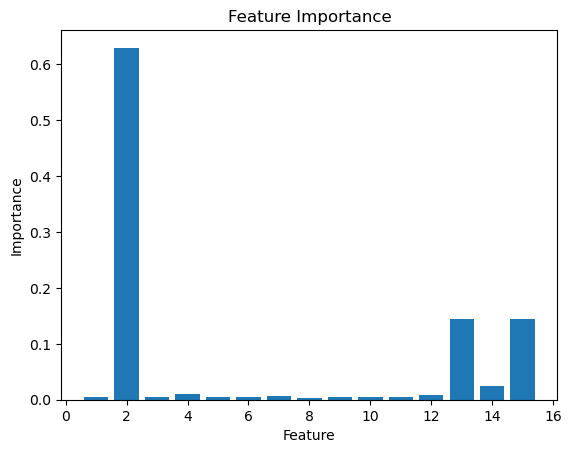

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the random forest classifier with optimal parameters
rfc_best = RandomForestClassifier(**grid_search.best_params_)
rfc_best.fit(train_data_feature, train_data_label)

# Calculate feature importance
feature_importance = rfc_best.feature_importances_

# Output feature importance into a table
feature_importance_df = pd.DataFrame({"feature": range(1, len(feature_importance)+1), "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False).reset_index(drop=True)
print(feature_importance_df)

# Output feature importance as a graph
plt.bar(feature_importance_df["feature"], feature_importance_df["importance"])
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


## 5.5 Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg = LogisticRegression()

logreg = logreg.fit(train_data_feature, train_data_label)
y_pred_logreg = logreg.predict(test_data_feature)

# mae
test_error_rfc_logre = mean_absolute_error(test_data_label, y_pred_logreg)
print("mae is ", test_error_rfc_logre)

# mse
test_error_rfc_logre = mean_squared_error(test_data_label, y_pred_logreg)
print("mse is ", test_error_rfc_logre)

# r2_score
test_r2_score = r2_score(test_data_label, y_pred_logreg)
print("r2 is ", test_r2_score)

mae is  11.810410958904109
mse is  536.0482191780821
r2 is  -0.33028043287866216


## 5.6 XgBoost

In [53]:
import xgboost as xgb

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(train_data_feature, train_data_label)

y_pred_xgboost = x_model.predict(test_data_feature)

# mae
test_error_xgboost_mae = mean_absolute_error(test_data_label, y_pred_xgboost)
print("mae is ", test_error_xgboost_mae)

# mse
test_error_xgboost_mse = mean_squared_error(test_data_label, y_pred_xgboost)
print("mse is ", test_error_xgboost_mse)

# r2_score
test_r2_score = r2_score(test_data_label, y_pred_xgboost)
print("r2 is ", test_r2_score)

mae is  0.28524118287922584
mse is  0.23653357336665579
r2 is  0.9994130080595156


## 5.8 Validation

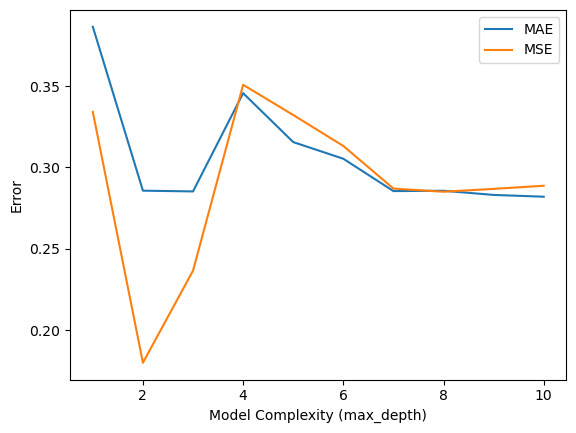

In [54]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# initialize model
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)

# define list of complexity values to test
complexity = range(1, 11)

# initialize lists to store MAE and MSE values
mae_values = []
mse_values = []

# loop through complexity values and train models
for c in complexity:
    # set model complexity
    x_model.set_params(max_depth=c)
    
    # train model
    x_model.fit(train_data_feature, train_data_label)
    
    # make predictions on test set
    y_pred_xgboost = x_model.predict(test_data_feature)
    
    # calculate MAE and MSE
    test_error_xgboost_mae = mean_absolute_error(test_data_label, y_pred_xgboost)
    test_error_xgboost_mse = mean_squared_error(test_data_label, y_pred_xgboost)
    
    # add values to lists
    mae_values.append(test_error_xgboost_mae)
    mse_values.append(test_error_xgboost_mse)

# plot MAE and MSE values against complexity
plt.plot(complexity, mae_values, label='MAE')
plt.plot(complexity, mse_values, label='MSE')
plt.xlabel('Model Complexity (max_depth)')
plt.ylabel('Error')
plt.legend()
plt.show()
